# Analysis of Changes in Biodiveristy Intactness Index (BII) in the Phoenix Metro Area

Author: Rachel Swick

Date: December 12, 2024

Github Link: https://github.com/rfswick/bii-changes-maricopa-county.git

## Purpose

To understand changes in BII in Maricopa County, which contains the Phoenix metro area, by creating visualizations showing BII in Maricopa County.

## Highlights

- Use an API to load data
- Manipulating raster data with rioxarray
- Manipulating raster data through raster math

## About the Data

**Biodiversity Intactness Index (BII) Time Series**: This data is avaliable through the Microsoft Planetary Computer STAC catalog. Raster data depicting the intactness of biodiversity.

**Phoenix Subdivision Shapefile**: Shapefile of the Phoenix Subdivision as a subset of the larger shapefile of Arizona county subdivisions. Obtained from the United States Census Bureau.

## References

Biodiversity Intactness, Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. https://doi.org/10.5281/zenodo.7261897

2022 TIGER/Line® Shapefiles: County Subdivisions, US Census Bureau, Geography Division. (2022). https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

## Import Libraries

In [1]:
# Load libraries
import contextily as cx
import numpy as np
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import rioxarray as rioxr
from pystac_client import Client
import planetary_computer
from IPython.display import Image

## Load Data

### Biodiversity Intactness Index (BII) Time Series Data

Download the Biodiversity Intactness Index (BII) Time Series data from the Microsoft Planetary Computer STAC catalog. The SpatioTemporal Asset Catalog (STAC) is a new standard for geospatial data, particulary for satellite imagery. To obtain data from a STAC catalog, we use an Application Programming Interface (API). The API acts as an intermediary between the STAC catalog and ourselves.

In [2]:
# Load BII data for 2017 and 2020
# Access MPC catalog
catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
)

# Maricopa county bounding box
bbox = {
        "type": "Polygon",
        "coordinates":[
        [
            [-112.826843, 32.974108],  # lower left corner (longitude, latitude)
            [-111.184387, 32.974108],  # lower right corner
            [-111.184387, 33.863574],  # upper right corner
            [-112.826843, 33.863574],  # upper left corner
            [-112.826843, 32.974108]   # closing the polygon (same as start point)
        ]
    ],
}

# Search catalog and retrieve search items
items = catalog.search(
        collections = ['io-biodiversity'],
        intersects = bbox).item_collection()

# Four items in the catalog match the search
# Determine which items in the list contain 2017 and 2020 bii data
list(items)

[<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>,
 <Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>,
 <Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>,
 <Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>]

In [3]:
# Select the 2017 and 2020 items in the catalog search
year_17 = items[3]
year_20 = items[0]

# Print `year_17` ID and assets
print('ID:' , year_17.id, '\n')
for key in year_17.assets.keys():
    print(key, '--', year_17.assets[key].title)

# Print `year_20` ID and assets
print('\nID:' , year_20.id, '\n')
for key in year_20.assets.keys():
    print(key, '--', year_20.assets[key].title)

ID: bii_2017_34.74464974521749_-115.38597824385106_cog 

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview

ID: bii_2020_34.74464974521749_-115.38597824385106_cog 

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [4]:
# Load 2017 and 2020 BII data
bii_17 = rioxr.open_rasterio(year_17.assets['data'].href)
bii_20 = rioxr.open_rasterio(year_20.assets['data'].href)

### Phoenix Subdivision Shapefile

In [5]:
# Load Arizona county subdivisions
arizona_subdivisions = gpd.read_file(os.path.join('data', 'tl_2022_04_cousub', 'tl_2022_04_cousub.shp'))

# Filter to Phoenix subdivision
phoenix_subdivision = arizona_subdivisions[arizona_subdivisions['NAME'] == 'Phoenix']

## Data Exploration

Before we begin our analysis, we need to explore our data to ensure we know what we are working with and to determine if any cleaning of our data is required.

### BII Data Exploration

In [6]:
# Basic description of `io-biodiversity` collection
catalog.get_child('io-biodiversity')

<CollectionClient id=io-biodiversity>

### 2017 BII Data Exploration

In [7]:
# Display `bii_17` contents
bii_17

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
# Display the shape, data type, and dimensions of the underlying array
print('Shape: ', bii_17.shape)
print('Data type: ', bii_17.dtype)
print("Dimensions:", bii_17.dims)

Shape:  (1, 7992, 7992)
Data type:  float32
Dimensions: ('band', 'y', 'x')


In [9]:
# Display the coordinates in `bii_20`
bii_17.coords

Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0

### 2020 BII Data Exploration

In [10]:
# Display `bii_20` contents
bii_20

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
# Display the shape, data type, and dimensions of the underlying array
print('Shape: ', bii_20.shape)
print('Data type: ', bii_20.dtype)
print("Dimensions:", bii_20.dims)

Shape:  (1, 7992, 7992)
Data type:  float32
Dimensions: ('band', 'y', 'x')


In [12]:
# Display the coordinates in `bii_20`
bii_20.coords

Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0

### Phoenix Subdivision Data

In [13]:
# Display first 5 rows of `phoenix_subdivision`
phoenix_subdivision.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


In [14]:
# Determine the data types of the columns
phoenix_subdivision.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CNECTAFP      object
NECTAFP       object
NCTADVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [32]:
# Determine the number of rows and columns
phoenix_subdivision.shape

(1, 19)

### Data Exploration Summary

Both the 2017 and 2020 BII data has three dimensions (x, y, band), and they are the same shape. The band dimension contains no information and is making the dataset needlessly three dimensional. The Phoenix subdivision data has one row and nineteen columns. The geodataframe has a column geometery, containing type geometery.

## Cleaning

Each year of biodiversity intactness index (IDD) data contains an extra band making the data 3-dimensional when that is not necessary. Remove the band to make the data 2-dimensional and easier to work with.

In [15]:
# Original dimensions and coordinates
print(bii_17.dims, bii_17.coords, '\n')
print(bii_20.dims, bii_20.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [16]:
# Remove band dimension
# Remove coordinates associated to band
bii_17 = bii_17.squeeze()
bii_17 = bii_17.drop_vars('band')
print(bii_17.dims, bii_17.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [17]:
# Remove band dimension
# Remove coordinates associated to band
bii_20 = bii_20.squeeze()
bii_20 = bii_20.drop_vars('band')
print(bii_20.dims, bii_20.coords)

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


## Map of the Phoenix Subdivision

Create a map of the Phoenix Subdivision in Maricopa County, Arizona within a greater geographic context. 

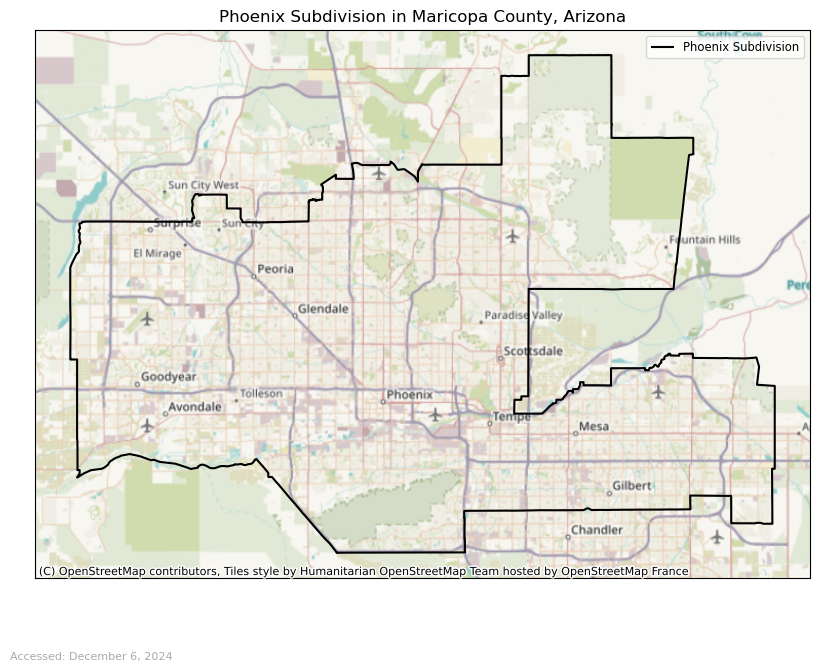

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(10, 8))  

# Add phoenix subdivision data
phoenix_subdivision.geometry.boundary.plot(ax=ax,
                                           color='black',
                                           linewidth=1.5,
                                           label="Phoenix Subdivision")

# Add geographic context
cx.add_basemap(ax, crs=phoenix_subdivision.crs)

# Add legend
ax.legend(fontsize='small')

# Add title
ax.set_title("Phoenix Subdivision in Maricopa County, Arizona")  

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("") 

# Add credits
plt.figtext(0.1, 0.05, 
            "Accessed: December 6, 2024", 
            fontsize=8, 
            color="darkgrey")

plt.show()

## Percent of the Phoenix Metro Area with a BII of at Least 0.75 in 2017

We are interested in how the amount of area with a BII of at least 0.75 has changed in the Phoenix Subdivision between 2017 and 2020. In order to do this, we must first calculate the percent of the Phoenix Subdivision with a BII of at least 0.75 in 2017. Steps to accomplish this include:

1. Check that the CRS of the data match.
2. Clip the 2017 BII raster data to the Phoenix Subdivsion polygon.
3. Create a dataframe of the number of unique pixel values within the clipped BII raster.
4. Determine the total number of pixels in the clipped raster.
5. Determine the number of pixels with a BII of at least 0.75.
6. Determine the percent of the Phoenix Subdivision with a BII of at least 0.75 in 2017.

In [19]:
# Confirm the CRS of the data match
if phoenix_subdivision.crs == bii_17.rio.crs:
    print("The CRS match.")
else:
    phoenix_subdivision = phoenix_subdivision.to_crs(bii_17.rio.crs)
    print("The CRS match.")
    
assert phoenix_subdivision.crs == bii_17.rio.crs

The CRS match.


In [20]:
# Clip raster to Phoenix subdivision polygon
clip_step_1 = bii_17.rio.clip_box(*phoenix_subdivision.total_bounds)
phoenix_17_bii = clip_step_1.rio.clip(phoenix_subdivision.geometry)

In [21]:
# Number of pixels per unique BII value
# Create data frame 
pix_counts_17 = (pd.DataFrame(np.unique(phoenix_17_bii, return_counts=True))
                   .transpose()
                   .rename(columns={0: "bii_value", 1: "pix_count"})
                )
pix_counts_17

,bii_value,pix_count
0,0.070590,1.0
1,0.071102,1.0
2,0.071198,1.0
3,0.071554,1.0
4,0.071961,1.0
...,...,...
330091,0.880174,1.0
330092,0.880183,1.0
330093,0.880198,1.0
330094,0.880218,1.0


In [22]:
# Total number of pixels in the clipped raster
total_pixels_17 = pix_counts_17[pix_counts_17['bii_value'] >= 0].pix_count.sum()

# Return the number of pixels that contain bii >= 0.75
bii_pixels_17 = pix_counts_17[pix_counts_17['bii_value'] >= 0.75].pix_count.sum()

In [23]:
percent_17 = (bii_pixels_17/total_pixels_17) * 100
print("Percent of the Phoenix Subdivision with a BII of at least 0.75 in 2017:", round(percent_17, 2), "%")

Percent of the Phoenix Subdivision with a BII of at least 0.75 in 2017: 7.13 %


## Percent of the Phoenix Metro Area with a BII of at Least 0.75 in 2020

Now repeat the steps above for the 2020 data.

In [24]:
# Confirm the CRS of the data match
if phoenix_subdivision.crs == bii_20.rio.crs:
    print("The CRS match.")
else:
    phoenix_subdivision = phoenix_subdivision.to_crs(bii_20.rio.crs)
    print("The CRS match.")
    
assert phoenix_subdivision.crs == bii_20.rio.crs == bii_17.rio.crs

The CRS match.


In [25]:
# Clip raster to Phoenix subdivision polygon
clip_step_1 = bii_20.rio.clip_box(*phoenix_subdivision.total_bounds)
phoenix_20_bii = clip_step_1.rio.clip(phoenix_subdivision.geometry)

In [26]:
# Number of pixels per unique BII value
# Create data frame 
pix_counts_20 = (pd.DataFrame(np.unique(phoenix_20_bii, return_counts=True))
                   .transpose()
                   .rename(columns={0: "bii_value", 1: "pix_count"})
                )
pix_counts_20

,bii_value,pix_count
0,0.080150,1.0
1,0.085542,1.0
2,0.090434,1.0
3,0.092371,1.0
4,0.092681,1.0
...,...,...
330677,0.880174,1.0
330678,0.880183,1.0
330679,0.880198,1.0
330680,0.880218,1.0


In [27]:
# Total number of pixels in the clipped raster
total_pixels_20 = pix_counts_20[pix_counts_20['bii_value'] >= 0].pix_count.sum()

# Return the number of pixels that contain bii >= 0.75
bii_pixels_20 = pix_counts_20[pix_counts_20['bii_value'] >= 0.75].pix_count.sum()

In [28]:
percent_20 = (bii_pixels_20/total_pixels_20) * 100
print("Percent of the Phoenix Subdivision with a BII of at least 0.75 in 2020:", round(percent_20, 2), "%")

Percent of the Phoenix Subdivision with a BII of at least 0.75 in 2020: 6.49 %


## Map of area with BII >= 0.75 in 2017 that was lost by 2020

To determine which areas no longer have a BII of at least 0.75 in 2020, that did in 2017, we must first determine what areas had a BII of at least 0.75 in both 2017 and 2020. A little raster math is then conducted to subtract the filtered rasters from eachother to show which areas no longer have a BII of at least 0.75 in 2020. The figure below visualizes this loss in BII.

In [29]:
# 2017 clipped raster where BII >= 0.75  
bii2017_75 = phoenix_17_bii >= 0.75

# 2020 clipped raster where BII >= 0.75
bii2020_75 = phoenix_20_bii >= 0.75

# Difference between 2017 and 2020
diff = bii2017_75.astype('int') - bii2020_75.astype('int')

# Set all pixels where the difference is not equal to 1 to NA
diff = diff.where(diff == 1)

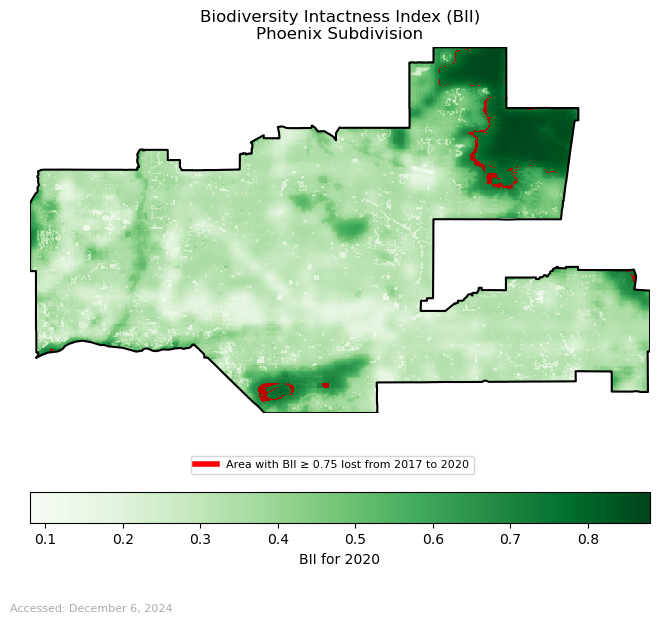

In [30]:
# Plot
bii_aspect_ratio = phoenix_20_bii.rio.width / phoenix_20_bii.rio.height
fig, ax = plt.subplots(figsize=(8, 4 * bii_aspect_ratio))  

# Add bii values for 2020
phoenix_20_bii.plot.imshow(ax=ax,
                           cmap='Greens',
                           cbar_kwargs={'orientation': 'horizontal',
                                        'label': 'BII for 2020'})

# Add phoenix subdivision data
phoenix_subdivision.geometry.boundary.plot(ax=ax,
                                           color='black',
                                           linewidth=1.5)

# Add where BII was >= 0.75 in 2017 but not in 2020
diff.plot.imshow(ax=ax,
                 cmap='gist_heat',
                 add_colorbar = False)

# Add legnd
red_patch = mlines.Line2D([], [], color='red', label='Area with BII ≥ 0.75 lost from 2017 to 2020', linewidth=4)
ax.legend(handles=[red_patch], bbox_to_anchor = (0, 0, 0.725, -0.1), fontsize=8)

# Add title
ax.set_title("Biodiversity Intactness Index (BII)\nPhoenix Subdivision")  

# Remove axes
ax.axis('off')

# Add credits
plt.figtext(0.1, 0.05, 
            "Accessed: December 6, 2024", 
            fontsize=8, 
            color="darkgrey")

# Display the map
plt.show()

The percent of the Phoenix subdivision with a Biodiversity Intactness Index (BII) of at least 0.75 decreased from 7.13% in 2017 to 6.49% in 2020. The figure above visualizes this change by highlighting the areas which had a BII of 0.75 in 2017, but no longer do as of 2020 (dark red areas on the figure). These areas are of particular note because they either border or are fully within areas that have a high BII value (dark green areas on the figure). While decreasing BII is concerning in itself, the location of this decrease is even more concerning. If you look at the map of the Phoenix Subdivison above, the areas where BII dropped below 0.75 from 2017 to 2020 are located in open, undeveloped spaces. The decrease in BII appears to indicate that urban sprawl is beginning to impact the biodiversity in these undeveloped spaces. 